### Feature Generation

Creating new features from raw data is one of the best ways to improve a model. In this case, we can calculate the total number of projects in the last week and the duration of the fundraising period. 

In [10]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.preprocessing import LabelEncoder

In [11]:
ks = pd.read_csv('../data/ks-projects-201801.csv', parse_dates=['deadline', 'launched'])

# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

# Timestamp features
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

# Label encoding
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
baseline_data = ks[data_cols].join(encoded)

### Interactions

One of the easiest ways to create new features is by combining categorical variables. For example, having the country `'CA'` and category `'Music'` can be combined to create a new value `'CA_Music'`. This could potentially provide information about correlations between categorical variables. This is called an interaction. 

In general, we build interaction features from all pairs of two categorical features. It is possible to make interactions from three or more features, but there will tend to be diminishing returns. 

In [13]:
ks.category.nunique(), ks.country.nunique()

(159, 23)

In [14]:
159 * 23

3657

Not all possible pairs show up. 

In [19]:
interactions = ks.category + '_' + ks.country
interactions.nunique()

2750

In [21]:
interactions.head(10)

0            Poetry_GB
1    Narrative Film_US
2    Narrative Film_US
3             Music_US
4      Film & Video_US
5       Restaurants_US
6              Food_US
7            Drinks_US
8    Product Design_US
9       Documentary_US
dtype: object

We can now label encode this

In [24]:
label_enc = LabelEncoder()

data_interaction = baseline_data.assign(category_country=label_enc.fit_transform(interactions))

In [25]:
data_interaction.head()

,goal,hour,day,month,year,outcome,category,currency,country,category_country
0,1000.0,12,11,8,2015,0,108,5,9,1900
1,30000.0,4,2,9,2017,0,93,13,22,1630
2,45000.0,0,12,1,2013,0,93,13,22,1630
3,5000.0,3,17,3,2012,0,90,13,22,1595
4,19500.0,8,4,7,2015,0,55,13,22,979


#### Number of projects in the last week

We may want to know the number of projects launched in the preceeding week for each record. Some weeks may be more competitive than others. We make `ks.launched` the index and `ks.index` the values of a Pandas series. We then sort the times. And use the `.rolling` method to define the rolling window size. 

In [37]:
launched = pd.Series(ks.index, index=ks.launched, name='count_7_days').sort_index()

In [39]:
launched.head(20)

launched
1970-01-01 01:00:00     94579
1970-01-01 01:00:00    319002
1970-01-01 01:00:00    247913
1970-01-01 01:00:00     48147
1970-01-01 01:00:00     75397
1970-01-01 01:00:00      2842
1970-01-01 01:00:00    273779
2009-04-21 21:02:48    169268
2009-04-23 00:07:53    322000
2009-04-24 21:52:03    138572
2009-04-25 17:36:21    325391
2009-04-27 14:10:39    122662
2009-04-28 13:55:41    213711
2009-04-29 02:04:21    345606
2009-04-29 02:58:50    235255
2009-04-29 04:37:37     98954
2009-04-29 05:26:32    342226
2009-04-29 06:43:44    275091
2009-04-29 13:52:03    284115
2009-04-29 22:08:13     32898
Name: count_7_days, dtype: int64

Most likely the first seven projects have wrong launch dates. 

With a timeseries index, you can use `.rolling` to select time periods as the window. For example `launched.rolling('7d')` creates a rolling window that contains all the data in the previous 7 days. The window contains the current record, so if we want to count all the *previous* projects but not the current one, we'll need to subtract 1. We'll plot the results to make sure it looks right.

In [45]:
launched.rolling('7d').count()

launched
1970-01-01 01:00:00     1.0
1970-01-01 01:00:00     2.0
1970-01-01 01:00:00     3.0
1970-01-01 01:00:00     4.0
1970-01-01 01:00:00     5.0
                       ... 
2017-12-29 03:22:32    23.0
2017-12-29 21:06:11    20.0
2017-12-31 13:53:53    16.0
2018-01-01 00:54:41    17.0
2018-01-02 03:05:10    18.0
Name: count_7_days, Length: 375862, dtype: float64

In [46]:
count_7_days = launched.rolling('7d').count() - 1

In [47]:
count_7_days

launched
1970-01-01 01:00:00     0.0
1970-01-01 01:00:00     1.0
1970-01-01 01:00:00     2.0
1970-01-01 01:00:00     3.0
1970-01-01 01:00:00     4.0
                       ... 
2017-12-29 03:22:32    22.0
2017-12-29 21:06:11    19.0
2017-12-31 13:53:53    15.0
2018-01-01 00:54:41    16.0
2018-01-02 03:05:10    17.0
Name: count_7_days, Length: 375862, dtype: float64

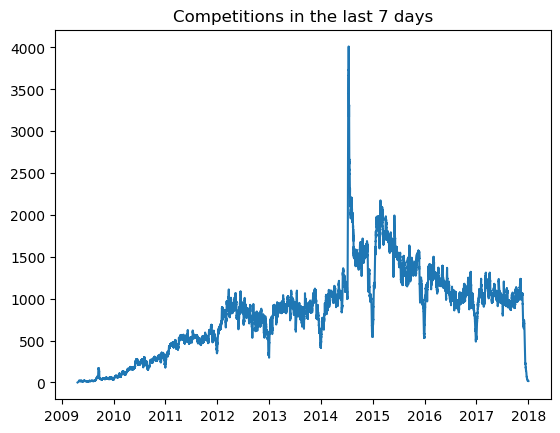

In [50]:
# Ignore records with broken launch dates
plt.plot(count_7_days[7:]);
plt.title("Competitions in the last 7 days");

We can now adjust the index of the counts so that we can joint it with the other training data. 

Remember the launched values is the `ks` index. 

In [54]:
count_7_days.index = launched.values

In [65]:
count_7_days

94579      0.0
319002     1.0
247913     2.0
48147      3.0
75397      4.0
          ... 
339929    22.0
62039     19.0
11463     15.0
167940    16.0
15604     17.0
Name: count_7_days, Length: 375862, dtype: float64

In [66]:
# Confirm the value at index 0 
count_7_days[0]

1409.0

We use `Pandas.DataFrame.reindex` to conform the DataFrame, because remember we sorted the entries by date-time. 

In [67]:
count_7_days = count_7_days.reindex(ks.index)

In [68]:
count_7_days

0         1409.0
1          957.0
2          739.0
3          907.0
4         1429.0
           ...  
378656    1482.0
378657     505.0
378658     238.0
378659    1100.0
378660     542.0
Name: count_7_days, Length: 375862, dtype: float64

In [69]:
baseline_data.join(count_7_days)

,goal,hour,day,month,year,outcome,category,currency,country,count_7_days
0,1000.0,12,11,8,2015,0,108,5,9,1409.0
1,30000.0,4,2,9,2017,0,93,13,22,957.0
2,45000.0,0,12,1,2013,0,93,13,22,739.0
3,5000.0,3,17,3,2012,0,90,13,22,907.0
4,19500.0,8,4,7,2015,0,55,13,22,1429.0
...,...,...,...,...,...,...,...,...,...,...
378656,50000.0,2,17,9,2014,0,39,13,22,1482.0
378657,1500.0,3,22,6,2011,0,93,13,22,505.0
378658,15000.0,19,1,7,2010,0,93,13,22,238.0
378659,15000.0,18,13,1,2016,0,138,13,22,1100.0


#### Time since the last project in the same category

Maybe projects in the same category compete for donors. If the time since the last project in the same category is high, then that might indicate success. 

We can get this by using `.groupby` then `.transform`. The `.transform` method takes a function then passes a series or dataframe to that function for each group. 

In [83]:
ks.launched.sort_values()

94579    1970-01-01 01:00:00
319002   1970-01-01 01:00:00
247913   1970-01-01 01:00:00
48147    1970-01-01 01:00:00
75397    1970-01-01 01:00:00
                 ...        
339929   2017-12-29 03:22:32
62039    2017-12-29 21:06:11
11463    2017-12-31 13:53:53
167940   2018-01-01 00:54:41
15604    2018-01-02 03:05:10
Name: launched, Length: 375862, dtype: datetime64[ns]

In [132]:
ks.launched.sort_values().diff().dt.total_seconds() / 3600

94579                NaT
319002   0 days 00:00:00
247913   0 days 00:00:00
48147    0 days 00:00:00
75397    0 days 00:00:00
               ...      
339929   0 days 04:31:49
62039    0 days 17:43:39
11463    1 days 16:47:42
167940   0 days 11:00:48
15604    1 days 02:10:29
Name: launched, Length: 375862, dtype: timedelta64[ns]

In [101]:
def time_since_last_project(series):
    # Return the time in hours
    return series.diff().dt.total_seconds() / 3600

In [104]:
df = ks[['category', 'launched']].sort_values('launched')

In [105]:
df.head()

,category,launched
94579,Theater,1970-01-01 01:00:00
319002,Publishing,1970-01-01 01:00:00
247913,Music,1970-01-01 01:00:00
48147,Art,1970-01-01 01:00:00
75397,Film & Video,1970-01-01 01:00:00


In [108]:
timedeltas = df.groupby('category').transform(time_since_last_project)

In [114]:
timedeltas.head(20)

,launched
94579,NaN
319002,NaN
247913,NaN
48147,NaN
75397,NaN
2842,0.000000
273779,NaN
169268,NaN
322000,NaN
138572,NaN


We get `NaNs` for projects that are the first in their category. We'll need to fill those in with something like the mean or median. We'll also need to reset the index so we can join it with the other data.

In [124]:
timedeltas = timedeltas.fillna(timedeltas.mean()).reindex(baseline_data.index)

In [125]:
timedeltas.head(20)

,launched
0,18.606111
1,5.592778
2,1.313611
3,0.635000
4,16.661389
5,2.629722
6,0.367500
7,12.286111
8,14.243611
9,0.174722


### Transforming numerical features

Most projects have goals less than 5000 USD. However, there is a long tail of goals going up to $100,000. Some models work better when the features are normally distributed, so it might help to transform the goal values. Common choices for this are the square root and natural logarithm. These transformations can also help constrain outliers.

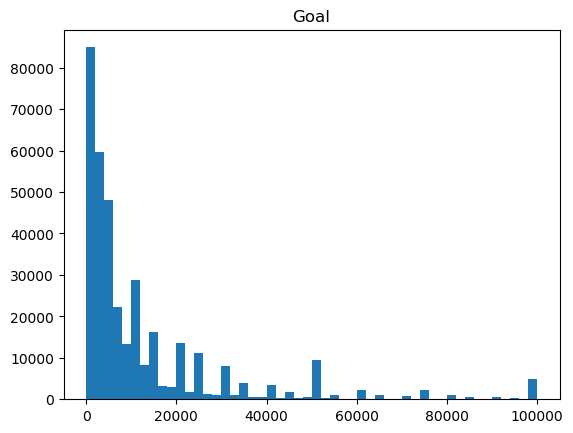

In [127]:
plt.hist(ks.goal, range=(0, 100_000), bins=50);
plt.title('Goal');

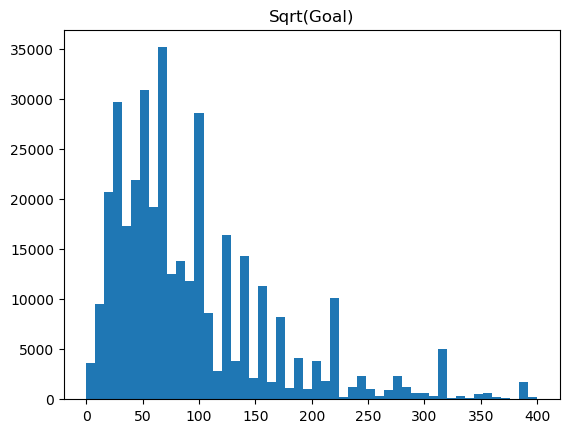

In [128]:
plt.hist(np.sqrt(ks.goal), range=(0, 400), bins=50);
plt.title('Sqrt(Goal)');

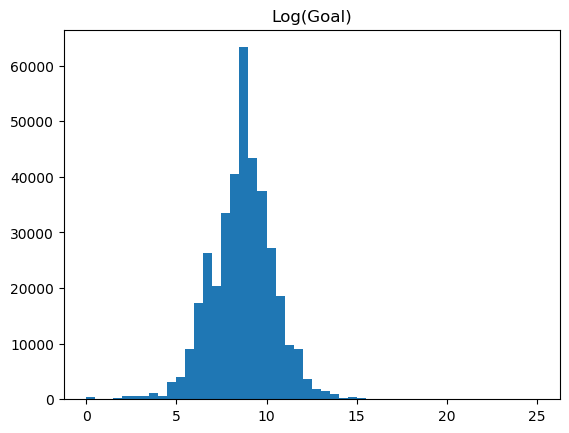

In [130]:
plt.hist(np.log(ks.goal), range=(0, 25), bins=50);
plt.title('Log(Goal)');

The log transformation won't help our model since tree-based models are scale invariant. However, this should help if we had a linear model or neural network.

Other transformations include squares and other powers, exponentials, etc. These might help the model discriminate, like the kernel trick for SVMs. Again, it takes a bit of experimentation to see what works. One method is to create a bunch of new features and later choose the best ones with feature selection algorithms.

These features themselves will work for either neural networks as well as tree-based models. However, numerical inputs to neural networks need to be standardized first. That is, the features need to be scaled such that they have 0 mean and a standard deviation of 1. This can be done using `sklearn.preprocessing.StandardScaler`.


In [136]:
test = baseline_data[:50]

In [145]:
s = test.outcome

In [173]:
s[:10]

0    0
1    0
2    0
3    0
4    0
5    1
6    1
7    0
8    0
9    0
Name: outcome, dtype: int64

In [183]:
list(zip(s[:10], (s.expanding(min_periods=2).sum() - s)[:10]))

[(0, nan),
 (0, 0.0),
 (0, 0.0),
 (0, 0.0),
 (0, 0.0),
 (1, 0.0),
 (1, 1.0),
 (0, 2.0),
 (0, 2.0),
 (0, 2.0)]

In [156]:
(s.values == 1).cumsum()

array([ 0,  0,  0,  0,  0,  1,  2,  2,  2,  2,  2,  3,  3,  3,  4,  4,  4,
        4,  5,  5,  6,  6,  6,  6,  7,  8,  8,  9, 10, 11, 11, 12, 13, 13,
       14, 14, 15, 16, 16, 17, 18, 19, 19, 20, 20, 21, 22, 23, 23, 24])

In [152]:
s.values.cumsum()

array([ 0,  0,  0,  0,  0,  1,  2,  2,  2,  2,  2,  3,  3,  3,  4,  4,  4,
        4,  5,  5,  6,  6,  6,  6,  7,  8,  8,  9, 10, 11, 11, 12, 13, 13,
       14, 14, 15, 16, 16, 17, 18, 19, 19, 20, 20, 21, 22, 23, 23, 24])

In [138]:
test..loc[test.outcome == 1]

,goal,hour,day,month,year,outcome,category,currency,country
5,50000.0,13,26,2,2016,1,123,13,22
6,1000.0,18,1,12,2014,1,58,13,22
11,12500.0,6,9,3,2013,1,72,13,22
14,5000.0,19,5,4,2017,1,136,5,9
18,250.0,14,2,8,2012,1,90,13,22
20,20000.0,7,25,11,2013,1,52,13,22
24,175.0,17,23,10,2014,1,26,13,22
25,10000.0,23,7,12,2010,1,90,13,22
27,17757.0,18,14,11,2014,1,153,1,3
28,100.0,16,29,12,2015,1,26,5,9


In [150]:
test

,goal,hour,day,month,year,outcome,category,currency,country
0,1000.0,12,11,8,2015,0,108,5,9
1,30000.0,4,2,9,2017,0,93,13,22
2,45000.0,0,12,1,2013,0,93,13,22
3,5000.0,3,17,3,2012,0,90,13,22
4,19500.0,8,4,7,2015,0,55,13,22
5,50000.0,13,26,2,2016,1,123,13,22
6,1000.0,18,1,12,2014,1,58,13,22
7,25000.0,20,1,2,2016,0,41,13,22
8,125000.0,18,24,4,2014,0,113,13,22
9,65000.0,21,11,7,2014,0,39,13,22
